### Logistics:

#### Group Members: Sagar Chadha, Ryan Hoff, Lu Hao Kuo, Cory Nguyen, Akhilesh Reddy
Forum being scraped: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/

## Code for the scraper:

In [100]:
# import selenium
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.support.ui import WebDriverWait
# import pandas as pd

# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--no-sandbox')
# chromepath = r'\chromedriver.exe'
# driver = webdriver.Chrome(executable_path = chromepath, chrome_options=chrome_options)


# def extracting_comments():
#     commentSet = driver.find_element_by_xpath('//*[@id="Content"]/div[4]/div[1]/ul')
#     comm_ids = commentSet.find_elements_by_tag_name('li')

#     comm_id_list = []
#     for comm_id in comm_ids:
#         comm_id_list.append(comm_id.get_attribute('id'))

#     # Cleaning blank strings from the list
#     comm_id_list_cleaned = [x for x in comm_id_list if x != '']

#     c_list = []
#     # Printing the comments for each discussion
#     for comm_id in comm_id_list_cleaned:
#         comm_userid = driver.find_elements_by_xpath(f'//*[@id="{comm_id}"]/div/div[2]/div[1]/span[1]/a[1]')
#         c_userid = comm_userid[0].get_attribute('title')
        
#         comm_date = driver.find_elements_by_xpath(f'//*[@id="{comm_id}"]/div/div[2]/div[2]/span/a/time')
#         c_date = comm_date[0].get_attribute('datetime')

#         comm_text =  driver.find_element_by_xpath(f'//*[@id="{comm_id}"]/div/div[3]/div/div[1]')
#         c_message = comm_text.text
        
#         block_quote =  driver.find_element_by_xpath(f'//*[@id="{comm_id}"]/div/div[3]/div/div[1]')
#         bq_1 = block_quote.find_elements_by_class_name('UserQuote')
#         if len(bq_1)!= 0:
#             b_message = bq_1[0].text
#         else:
#             b_message = ''
        
#         c_list.append([c_userid,c_date,c_message,b_message])
#     return c_list



# c_list_data = []

# if __name__ == "__main__":
#     i = 702
#     while i > 530:
#         url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{i}'
#         driver.get(url)
#         k = extracting_comments()
#         c_list_data.extend(k)
#         i -= 1

# comments_df = pd.DataFrame(c_list_data,columns = ['userid','date','comments','b_quote'])
# def blockquotes(a,b):
#     x = a.replace(b,'')
#     x = x.replace('\n','')
#     return x

# comments_df['cleaned_comments'] = comments_df.apply(lambda row: blockquotes(row['comments'],row['b_quote']),axis = 1)
# comments_df.to_csv('General auto comments_wo_bq.csv',index = False)

## Data Setup

In [1]:
import pandas as pd

# Import the data that will be used. models3.csv is an updated version of model-brand pairings and Attibutes3.csv
# is a list of feature-attribute pairings that will be used for Tasks C and D.

df = pd.read_csv('General auto comments_wo_bq.csv')
df1 = df.drop(columns = ['b_quote','comments'],axis = 1)
brand_model_mapping = pd.read_csv('models3.csv',engine='python')
attribute_mapping = pd.read_csv('Attributes3.csv',engine='python')

df1 = df1.dropna(subset = ['cleaned_comments'])
df1.reset_index(inplace= True)
df1 = df1.drop(['index'],axis = 1)

In [6]:
# Prepare a dictionary to replace Models with Brands
bm_mapping = {}
import re
for i in range(0,brand_model_mapping.shape[0]):
    s = brand_model_mapping.loc[i,'model'].strip().lower()
    bm_mapping[s] = brand_model_mapping.loc[i,'brand']

In [7]:
import nltk
from nltk import word_tokenize

# Identifying the unique words in each post
split_comments = []
for i in range(0,df1.shape[0]):
    split_comments.append(word_tokenize(df1.loc[i,'cleaned_comments'].lower()))
df1['split_comments'] = split_comments

# Replacing the models
cl1 = []
for i in range(0,df1.shape[0]):
    cl1.append(set([bm_mapping.get(n, n) for n in df1.loc[i,'split_comments']]))

In [1]:
# Importing the stopwords for later
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [9]:
# Remove stopwords and get the word frequencies for each comment on the forum.
final_list = []
for c in cl1:
    final_list.extend(c)

list_wo_stopwords = []
for w in final_list:
    if w not in stop_words:
        list_wo_stopwords.append(w)

fdist = nltk.FreqDist(w.lower() for w in list_wo_stopwords)

In [10]:
# Get the mention frequency for all brands
word_counts = dict(fdist)
brand_list_temp = set(brand_model_mapping['brand'])
brands_count = {k: word_counts.get(k, None) for k in brand_list_temp}

In [98]:
# Other approach
# # Counting the occurences of the brand in total
# brand_list_temp = set(brand_model_mapping['brand'])
# brand_list = {el:0 for el in brand_list_temp}

# for c in cl1:
#     for key,value in brand_list.items():
#         if key in c:
#             brand_list[key] = value + 1

In [11]:
# Get the top 10 brands
brands_sorted = sorted(brands_count.items(), key=lambda kv: kv[1],reverse = True)
top_brands = brands_sorted[:10]
top_brnds = {}
for l in top_brands:
    top_brnds[l[0]] = l[1]
top_brands

[('bmw', 1464),
 ('audi', 1104),
 ('acura', 659),
 ('mercedes', 431),
 ('cadillac', 341),
 ('honda', 337),
 ('infiniti', 329),
 ('volkswagen', 266),
 ('ford', 250),
 ('lexus', 200)]

The top 10 brands mentioned in the forum are: BMW, Audi, Acura, Mercedes, Cadillac, Honda, Infiniti, Volkswagen, Ford, and Lexus

## Task A: Identify top 10 brands by frequency. Show the brands on a multi-dimensional scaling (MDS) map.

In [12]:
# Creating pairs for the top 10 brands
import random
import itertools
 
def get_random_pairs(words):
  # Generate all possible non-repeating pairs
  pairs = list(itertools.permutations(words, 2))
 
  # Randomly shuffle these pairs
  # random.shuffle(pairs)
  return pairs

In [13]:
# Generate matched pairs for the top 10 brands
l = [k[0] for k in top_brands] 
random.seed(1)
pairs = get_random_pairs(l)

In [14]:
# Calculating presence of each pair in posts
pairs_dic = {k:0 for k in pairs}


for key,value in pairs_dic.items():
    a = key[0]
    b = key[1]
    for l in cl1:
        if a in l and b in l:
            pairs_dic[key] = pairs_dic[key] + 1

#lift value calculation
lift_dic = {}
for key,value in pairs_dic.items():
    cooccur = value
    # occurence of a
    a = key[0]
    b = key[1]
    occur_a = top_brnds[a]
    occur_b = top_brnds[b]
    lift_dic[key] = (len(cl1)*cooccur)/(occur_a*occur_b)

In [15]:
# Get the top 10 lift calculations for brand comparisons
lift_dic_sorted = sorted(lift_dic.items(), key=lambda kv: kv[1],reverse = True)
lift_dic_sorted[:10]

[(('infiniti', 'lexus'), 5.760303951367781),
 (('lexus', 'infiniti'), 5.760303951367781),
 (('mercedes', 'lexus'), 4.694176334106729),
 (('lexus', 'mercedes'), 4.694176334106729),
 (('cadillac', 'lexus'), 4.2057478005865105),
 (('lexus', 'cadillac'), 4.2057478005865105),
 (('acura', 'honda'), 3.7824056771567385),
 (('honda', 'acura'), 3.7824056771567385),
 (('acura', 'infiniti'), 3.401893815350697),
 (('infiniti', 'acura'), 3.401893815350697)]

In [16]:
# Create a dissimilarity matrix for use in the MDS plot
import numpy as np
k = pd.DataFrame(lift_dic_sorted)
k.columns = ['a','b']
k[['l1', 'l2']] = k['a'].apply(pd.Series)

k['lift_measure'] = 1/k['b']
max_diss_value = max(k[k['lift_measure'] != np.inf]['lift_measure'])

k2 = k.drop(columns = ['a','b'],axis = 1)
k3 = pd.pivot_table(k2,index = ['l1'],columns = ['l2'],values = ['lift_measure'])
k4 = k3.fillna(0).reset_index()
k5 = k4.replace(np.inf,max_diss_value)

In [17]:
# Create a table with all calculated lifts
lift_chart = pd.DataFrame(lift_dic_sorted)
lift_chart.columns = ['a','b']
lift_chart[['l1', 'l2']] = lift_chart['a'].apply(pd.Series)

lift_chart['lift'] = lift_chart['b']
lift_chart = lift_chart.drop(columns = ['a','b'],axis = 1)
lift_table = pd.pivot_table(lift_chart,index = ['l1'],columns = ['l2'],values = ['lift'])
lift_table = lift_table.fillna(0).reset_index()

lift_table

l1      lift                                                    \
l2                 acura      audi       bmw  cadillac      ford     honda   
0        acura  0.000000  1.851573  1.178599  1.846226  0.777238  3.782406   
1         audi  1.851573  0.000000  1.479947  2.217705  1.132036  1.679579   
2          bmw  1.178599  1.479947  0.000000  1.538989  1.665350  1.131606   
3     cadillac  1.846226  2.217705  1.538989  0.000000  1.562135  1.470853   
4         ford  0.777238  1.132036  1.665350  1.562135  0.000000  1.519881   
5        honda  3.782406  1.679579  1.131606  1.470853  1.519881  0.000000   
6     infiniti  3.401894  2.312695  1.637658  2.921926  1.432292  1.570698   
7        lexus  2.836920  2.574918  2.064194  4.205748  1.434160  2.811780   
8     mercedes  2.254171  2.551183  2.191720  3.136537  1.663759  1.763203   
9   volkswagen  1.431755  2.284863  1.223207  1.298767  1.925564  2.742643   

                                             
l2  infiniti     lexus  mercedes volkswagen  
0   3.401894  2.836920  2.254171   1.431755  
1   2.312695  2.574918  2.551183   2.284863  
2   1.637658  2.064194  2.191720   1.223207  
3   2.921926  4.205748  3.136537   1.298767  
4   1.432292  1.434160  1.663759   1.925564  
5   1.570698  2.811780  1.763203   2.742643  
6   0.000000  5.760304  2.853603   1.580250  
7   5.760304  0.000000  4.694176   1.925564  
8   2.853603  4.694176  0.000000   1.474330  
9   1.580250  1.925564  1.474330   0.000000

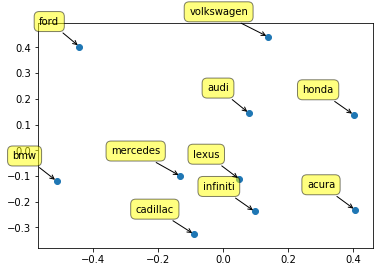

In [44]:
# Create the MDS plot with the top 10 mentioned brands
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

data = k5
data.columns = data.columns.get_level_values(0)
l = []
for i in range(0,data.shape[0]):
    l.append(list(data.iloc[i,:].values))

dists = []
cars = []
for d in l:
    cars.append(d[0])
    dists.append(d[1:])

adist = np.array(dists)
amax = np.amax(adist)
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )

from pylab import rcParams
plt.rcParams['figure.figsize'] = 10, 5

for label, x, y in zip(cars, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

## Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

Our MDS plot confirms the suspicions that Cadillac has successfully brought itself back from the dead. Enthusiasts have begun saying it has surpassed the German luxury brand BMW. To quote a recent verge article comparing the ATS-V, Cadillac’s prime performance model, with the BMW M3, “The idea that a Cadillac could ever compete with a M3 would once have been heresy. But the current generation M3 has lost its way.” This trend can be seen on the plot, where Cadillac has successfully rejoined the cluster ranks of true luxury with strong associations with Lexus, Infiniti and Mercedes.

## Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? 

In [95]:
# Show examples of the features mapped to attributes
attribute_mapping.groupby('Mapping').agg(lambda x: ' '.join(x))

,Feature
Mapping,
comfort,luxury room tall interior interiors luxurious ...
console,gps navigation nav dashboard monitor dash cons...
efficiency,efficiency mileage mpg gas efficient fuel economy
maintenance,warranty warranties maintenance repair service...
performance,performance awd fwd rwd power turbocharge hors...
safety,safety safe airbags airbag tires tire radial g...
styling,sunroof color paint alloys wheels wheel chrome...


In [96]:
# Creating the pairs between brands and attributes
top_5 = ['bmw','audi','acura','mercedes','honda']
final_attributes = list(set(attribute_mapping['Mapping']))
brand_att_pairs = []
for i in top_5:
    for j in final_attributes:
        brand_att_pairs.append((i,j))

In [97]:
# Calculating presence of each pair in posts
pairs_ba_dic = {k:0 for k in brand_att_pairs}

for key,value in pairs_ba_dic.items():
    a = key[0]
    b = key[1]
    k = list(attribute_mapping[attribute_mapping['Mapping'] == b]['Feature'])
    for l in cl1:
        if a in l and any(i in l for i in k):
            pairs_ba_dic[key] = pairs_ba_dic[key] + 1

final_attributes_count = {k:0 for k in final_attributes}
for a in final_attributes:
    k = list(attribute_mapping[attribute_mapping['Mapping'] == a]['Feature'])
    for l in cl1:
        if any(i in l for i in k):
            final_attributes_count[a] = final_attributes_count[a] + 1

# Lift value calculation
lift_ba_dic = {}
for key,value in pairs_ba_dic.items():
    cooccur = value
    # occurence of brand a
    a = key[0]
    b = key[1]
    occur_a = top_brnds[a]
    occur_b = final_attributes_count[b]
    lift_ba_dic[key] = (len(cl1)*cooccur)/(occur_a*occur_b)

In [98]:
# Show number of comments that mention a particular attribute
final_attributes_sorted = sorted(final_attributes_count.items(), key=lambda kv: kv[1],reverse = True)
final_attributes_sorted

[('performance', 1851),
 ('comfort', 741),
 ('maintenance', 474),
 ('styling', 425),
 ('safety', 366),
 ('efficiency', 354),
 ('console', 296)]

The top 5 are attributes mentioned are performance, comfort, maintenance, styling, and safety

In [99]:
# Show lift values between the top 5 brands and all 7 attributes
lift_ba_dic_sorted = sorted(lift_ba_dic.items(), key=lambda kv: kv[1],reverse = True)
lift_ba_dic_sorted

[(('honda', 'efficiency'), 2.1896595081225168),
 (('mercedes', 'comfort'), 2.1330239752513536),
 (('audi', 'styling'), 2.1068755328218245),
 (('honda', 'safety'), 2.076340581472653),
 (('honda', 'comfort'), 2.0511218699567912),
 (('acura', 'styling'), 2.0482513612425244),
 (('audi', 'console'), 2.0062671367019194),
 (('acura', 'comfort'), 1.9719404733381254),
 (('honda', 'console'), 1.9511989734541664),
 (('acura', 'console'), 1.864321453471681),
 (('audi', 'comfort'), 1.8532926519196542),
 (('honda', 'styling'), 1.8238575667655785),
 (('acura', 'efficiency'), 1.8223382457584252),
 (('audi', 'safety'), 1.7746693593094163),
 (('mercedes', 'styling'), 1.733664528456394),
 (('acura', 'safety'), 1.6988813983764106),
 (('audi', 'efficiency'), 1.6513448784082534),
 (('audi', 'maintenance'), 1.6150133003118694),
 (('audi', 'performance'), 1.5966271658876126),
 (('bmw', 'comfort'), 1.5911465823027515),
 (('acura', 'performance'), 1.5830298022067388),
 (('bmw', 'styling'), 1.5558630665380906),


### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   

Based on our lift calculations, BMW is far from being the "ultimate driving machine" on Edmunds. BMW and the different car attributes have comparitively low lift values to the other top brands. This implies that when people are talking about different desirable car features, BMW does not come to mind.

## Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive). 

i) Other than BMW, all of the other brands have high lift with the desirable car attributes. Each has a high lift exclusively in its own area, except for Audi and Acura. For the different product managers: Honda can continue working with its efficiency and safety features, Mercedes can continue working with its comfort features, and Audi and Acura can continue using their respective styling features. BMW and Mercedes both have extremely low lift values for several features. The product managers for these brands need to place greater emphasis on these feature areas.

ii) Honda's advertising manager is working with a product with several marketable strengths, such as efficiency, safety, and comfort. If the manager could do more to get people to associate performance with Honda, then Honda would have the strongest reputation that it possibly could among Edmunds forum users. Mercedes needs to market more of its features other than comfort, as it is the only feature Mercedes is the prime example for (in the top 5 brands). Audi and Acura both have styling as a part of their brand reputations. Advertising managers for these companies need not worry about the other since our MDS plot shows that Audi and Acura are dissimilar enough to imply that their markets have only small intersections. Lastly, BMW needs to do a better job at marketing its product overall. 

## Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand? 

In [2]:
# Words associated with Aspiration
asps = ["next car", "winner", "favor", "prefer", "most promise", "bang for your buck", "bang for buck", "go drive", 
       "go for", "dream of", "want", "heart", "dream", "buy", "purchase", "love", "wanted", "decided to", "desire",
       "desirable", "go with", "top of", "better value", "seriously look", "leaning", "look at", 
       'anticipate', 'expect']

In [3]:
# Build a lift class
class lift:
    N = 0
    corpus = None
    #input an array-like corpus to init
    def __init__(self, corpus):
        # required structure: a nested list with each sub-list place the document at place 2
        self.N = len(corpus)
        self.corpus = corpus
    
    def __count__(self, keyword1, keyword2 = None):
        if self.corpus == None:
            print("unspecified corpus")
            return
        count = 0
        if keyword2 == None:
            for node in self.corpus: 
                if keyword1 in node:
                    count = count +1 
            return count
        for node in self.corpus: 
            if keyword1 in node[2] and keyword2 in node[2]:
                count = count+1
        return count

In [4]:
# Define a function that will read each message, find brand mentions, identify an amount of words before and after the 
# brand mention and determine if a specified word(s) is within that span
def myIdentifier(article, brand, attribute, span = 3):
    rt = 0
    #define the span we're testing for
    leftpos = None
    rightpos = None
    #need to testify all the occurance of brand
    poses = [m.start() for m in re.finditer(brand, article)]
    for pos in poses: 
        temp = pos
        blank = 0
        #to prior
        while 1: 
            try:
                if article[pos] == "." or article[pos] == ";"  or article[pos] == "!" or article[pos] == "?":
                    leftpos = pos
                    break
                if blank == span+1 or pos ==0: 
                    leftpos = pos
                    break
                pos = pos-1
                if article[pos] == " ": 
                    blank = blank +1
            except IndexError: 
                leftpos = pos
                break
        pos = temp
        blank = 0
        #to post
        while 1: 
            try:
                if article[pos] == "." or article[pos] == ";" or article[pos] == "!" or article[pos] == "?":
                    rightpos = pos
                    break
                if blank == span+1: 
                    rightpos = pos
                    break
                pos = pos+1
                if article[pos] == " ": 
                    blank = blank +1
            except IndexError: 
                rightpos = pos-1
                break
        if attribute in article[leftpos:rightpos]:
            rt = rt+1
    return (rt>0)

In [18]:
brands = [i[0] for i in top_brands]

In [19]:
cl2 = []
for i in cl1:
    cl2.append(" ".join(i))

In [25]:
asp_bd = []
for brand in brands:  
    temp = {}
    for asp in asps:
        for node in cl2:
            article = node
            if(myIdentifier(article,brand,asp,10000)): # Set the span to 10000 to catch the entire comment
                if brand in temp.keys():
                    temp[brand] = temp[brand]+1
                    continue
                temp[brand] = 1
    asp_bd.append(temp)

In [26]:
import operator
myLift = lift(cl2)
asp_count = 0
for asp in asps:
    asp_count = asp_count + myLift.__count__(asp)
N = len(cl2)

aspiration_brand_count = 0
for node in cl2:
   comment = node
   if any(keyword in comment for keyword in asps) \
   and any(brand in comment for brand in brands):
       aspiration_brand_count = aspiration_brand_count + 1
    
asp_bd_lift = {}
for brand_asp in asp_bd:
    brand = "".join(brand_asp.keys())
    asp_bd_lift[brand] = \
    (N*brand_asp[brand])/(aspiration_brand_count*myLift.__count__(brand))

sorted(asp_bd_lift.items(), key=operator.itemgetter(1), reverse = True)

[('honda', 1.9607914248871696),
 ('mercedes', 1.7918773653913431),
 ('acura', 1.3986928612103329),
 ('lexus', 1.305976589468399),
 ('bmw', 1.2353593032957864),
 ('ford', 1.2165329975033694),
 ('audi', 1.2157948540608752),
 ('volkswagen', 1.1564533694583898),
 ('infiniti', 0.8337590655928196),
 ('cadillac', 0.10290719868201635)]

Based on our data, the most aspirational brand is Honda, followed closely by Mercedes. These two brands have lift values that are much higher than the rest of the brands in terms of the aspirational words defined above. This means that most people are talking about wanting a Honda. Honda can continue to market their cars and try to widen the gap between the other brands. We can credit Honda's success to the amount of dissimilarity that it exhibits in the MDS plot, as no other brands are close to Honda. Furthermore, Honda showed the most association with multiple attributes in Task C. This means that the brand is making itself differentiable (in a positive way) with its product and the different features avaiable. The business should continue to market Honda in this light.